### Simulating evolution of system state without a controller for the single intersection model

##### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import integrate
# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()

os.chdir("..")
sys.path.append(os.getcwd())

from models.one_intersection import OneIntersectionSystem

# Set random seed for reproducibility
np.random.seed(0)

#### Setting parameter values and initial conditions

These are dummy values for now, and will have to be tuned.

In [2]:
params = {
    'a': 0.6,
    'b': 0.2,
    'alpha': np.random.uniform(0.01,0.1,(4,)),
}
initial_state = np.array([1, 1, 1, 1])
initial_state.shape

(4,)

##### Initialising Model and Simulating

In [3]:
# initialising the system
single_intersection = OneIntersectionSystem(params, initial_state)
print(single_intersection)

Initializing OneIntersectionSystem with parameters:
a: 0.6
b: 0.2
alpha: [0.05939322 0.07436704 0.0642487  0.05903949]
Initial state:
[1 1 1 1]
Traffic Network Configuration and Parameters
---------------------------------------------
Rate of continuing straight (a): 0.6
Rate of turning left/right (b): 0.2
Ease of flow (alpha): [0.05939322 0.07436704 0.0642487  0.05903949]
Initial incoming traffic densities (P):
[1 1 1 1]

ASCII Representation of the Intersection Network
----------------------------------------------
        ↑   ↓       
        |   |       
  ------|---|------> 
        |   |        
        |   |        
<------ |---| ------  
        |   |        
        ↑   ↓        



In [4]:
# ------------------------------------------------------------
# Initialising the State, Sensor,
# Output vectors and the input vector
# ------------------------------------------------------------

 
t0 = 0.0        # [s] Initial time
tf = 15*60         # [s] Final time
N = tf//10     # Number of controller updates
t= np.linspace(t0,tf,N)

x = np.zeros((4,N))
x[:,0] = initial_state

y = np.zeros((4,N))
y[:,0] = single_intersection.sensor()

z = np.zeros((4,N))
z[:,0] = single_intersection.output() # Only the first two heights are measured

# Start with a constant input
# u_const = np.concatenate((np.zeros(30), np.ones(30)))
u_const = 0.5
# Random, constant disturbance
d_const = np.random.random_sample((4,))/10


print(f"Initial state: {x[:, 0]}")
print(f"Initial sensor: {y[:, 0]}")
print(f"Initial output: {z[:, 0]}")
print(f"Constant input: {u_const}")
print(f"Disturbance: {d_const}")

Sensor measurement: [0.05939322 0.07436704 0.0642487  0.05903949]
Sensor measurement: [0.05939322 0.07436704 0.0642487  0.05903949]
Initial state: [1. 1. 1. 1.]
Initial sensor: [0.05939322 0.07436704 0.0642487  0.05903949]
Initial output: [0.05939322 0.07436704 0.0642487  0.05903949]
Constant input: 0.5
Disturbance: [0.04236548 0.06458941 0.04375872 0.0891773 ]


In [5]:
sol = integrate.solve_ivp(single_intersection.process, [t0, tf], initial_state, method='BDF', args=([u_const, d_const]))
# Note - args is annoying to work with
sol.t[0], sol.t[-1]

(0.0, 900.0)

In [6]:
P_sol = (sol.y).T
time_sol = sol.t/60

##### Plotting results of deterministic nonlinear simulation

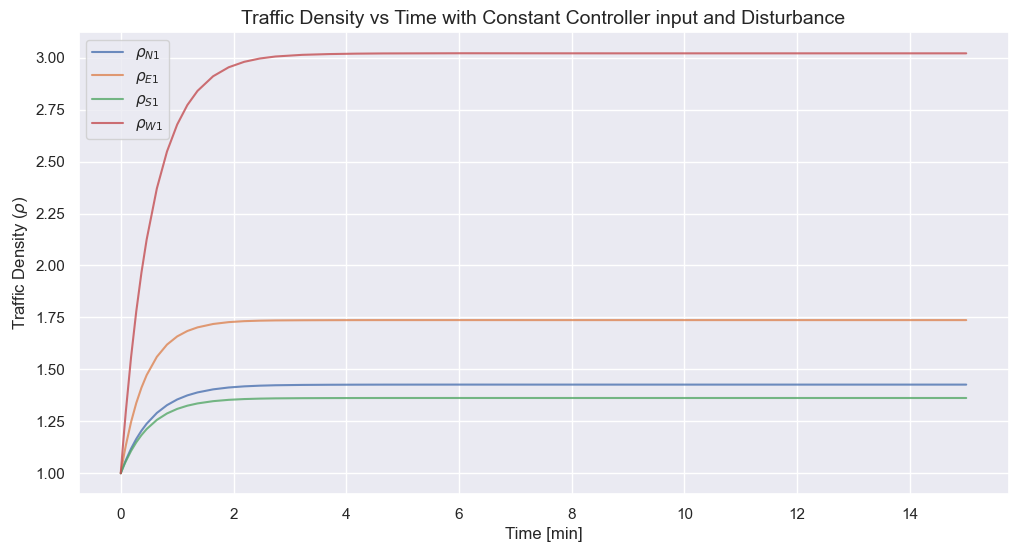

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(time_sol, P_sol, linestyle='-', alpha=0.8)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Constant Controller input and Disturbance', fontsize=14)

plt.savefig('figures/one_intersection/continuous_control_sim.png', dpi=300)
plt.show()


##### Simulating with binary controller (Switching from N-S to E-W every minute)

Transitioning to a discrete-time simulation

In [8]:
u_binary = np.random.randint(2, size=N)
X_d, T_d = initial_state.reshape(-1,1), np.array([0])

for k in range(0, N-1):
    sol = integrate.solve_ivp(single_intersection.process, [t[k], t[k+1]], x[:, k], method='BDF', args=([u_binary[k], d_const]))
    # Force non-negative densities
    sol.y[sol.y < 0] = 0
    x[:, k+1] = sol.y[:, -1]
    X_d = np.append(X_d, x[:, k+1].reshape(4,1), axis=1)
    T_d = np.append(T_d, sol.t[-1])
    
k = N-1

Plotting results from discrete-time simulation

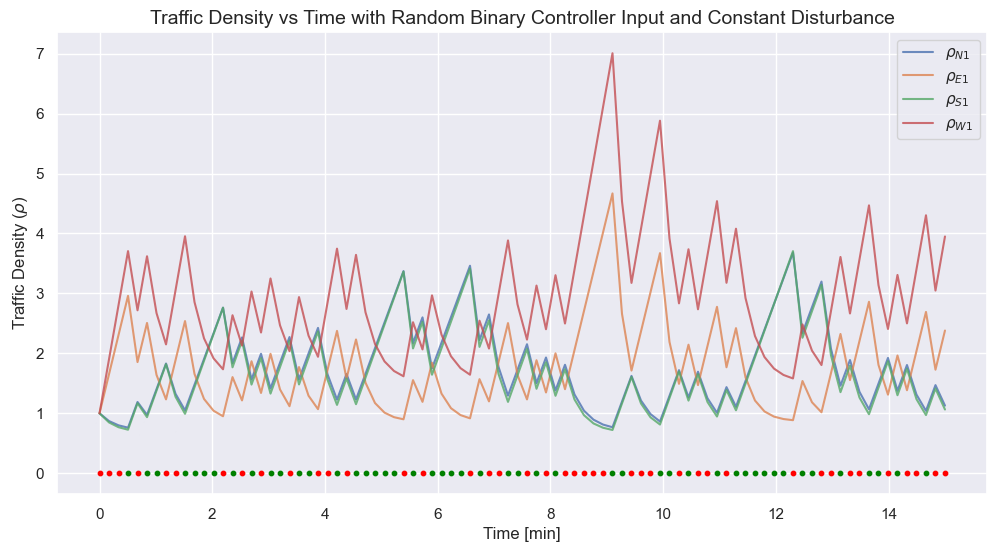

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(T_d/60, X_d.T, linestyle='-', alpha=0.8, markersize=5)
# Marking the controller values 
# plt.plot(T_d/60, u_binary, linestyle='-', marker='o', alpha=0.5)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Random Binary Controller Input and Constant Disturbance', fontsize=14)
# Mark switch points on the x-axis
c = lambda a: 'red' if a == 0 else 'green'
for i, x in enumerate(T_d/60):
    # plt.axvline(x=x, color=c(u_binary[i]), linestyle='--', alpha=0.7)  # Vertical line at each switch point
    plt.scatter(x, 0, color=c(u_binary[i]), s=10, zorder=3) 

plt.savefig('figures/one_intersection/rho_t_rand_bin_control_const_dist.png', dpi=300)
plt.show()

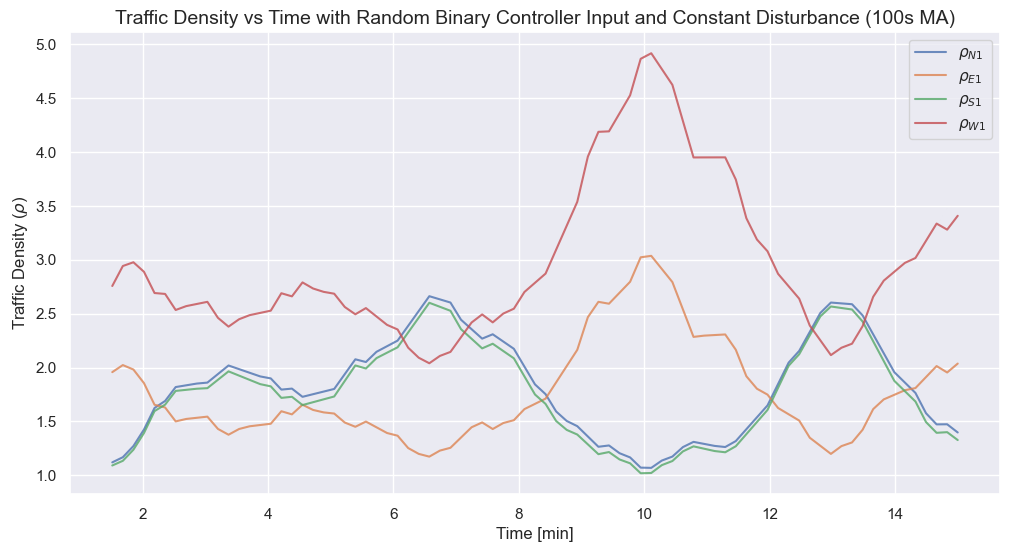

In [10]:
# Plot moving average of density values
plt.figure(figsize=(12, 6))
window = 10
for i in range(4):
    plt.plot(T_d[9:]/60, np.convolve(X_d[i, :], np.ones(window)/window, mode='valid'), linestyle='-', alpha=0.8)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Random Binary Controller Input and Constant Disturbance (100s MA)', fontsize=14)
plt.savefig('figures/one_intersection/rho_t_rand_bin_control_const_dist_moving_avg.png', dpi=300)
plt.show()

#### Stochastic external flow rate simulation

##### Constant controller value, stochastic disturbance

Asssuming that disturbances are normally distributed.

In [11]:
d_stochastic = np.zeros((4,N)) 
means = d_const 
for i in range(N):
    d_stochastic[:, i] = np.random.normal(means, 0.01)

d_stochastic.shape

(4, 90)

Sensor measurement: [0.06701389 0.17705927 0.06832027 0.23318218]
Sensor measurement: [0.06701389 0.17705927 0.06832027 0.23318218]


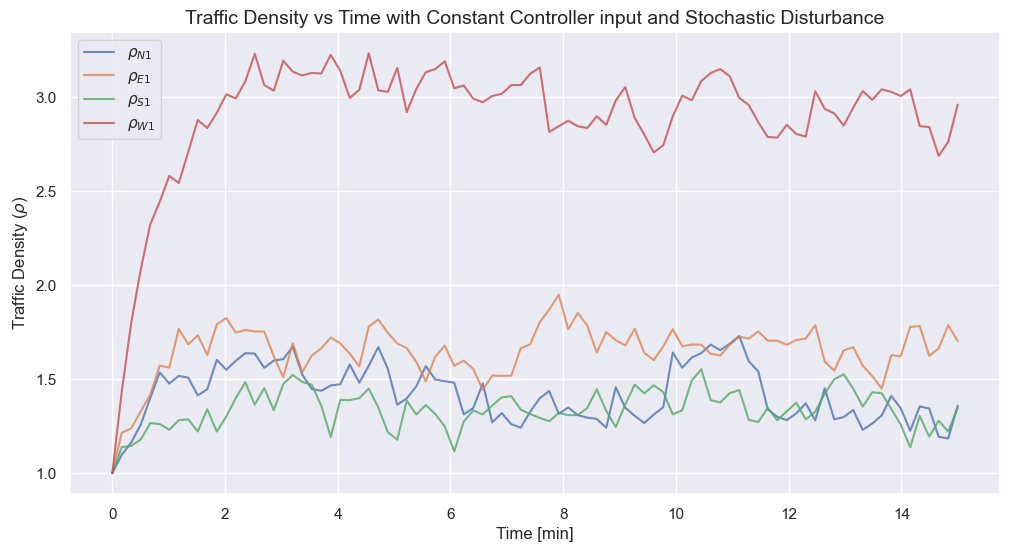

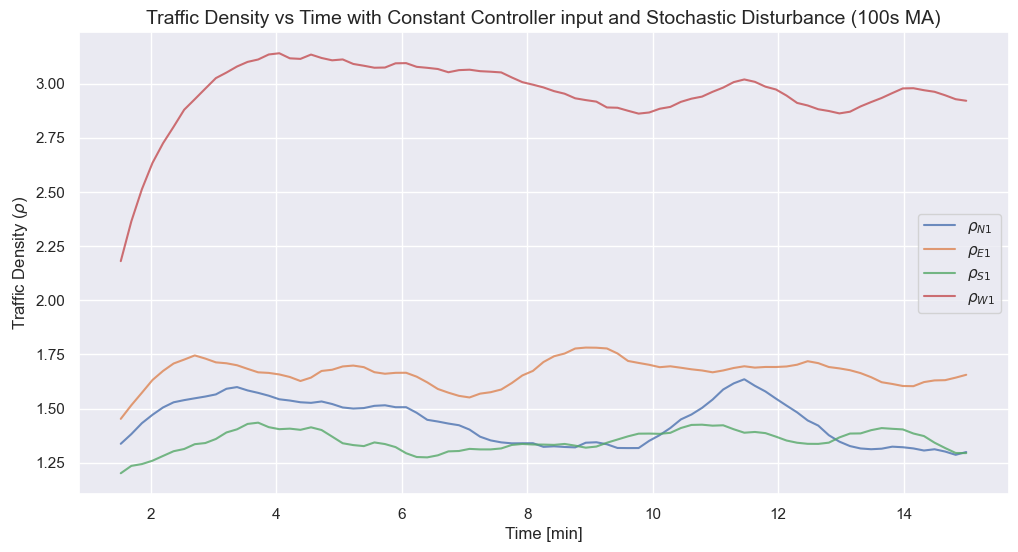

In [12]:
# Standard 
x = np.zeros((4,N))
x[:,0] = initial_state
y = np.zeros((4,N))
y[:,0] = single_intersection.sensor()
z = np.zeros((4,N))
z[:,0] = single_intersection.output() 

u_binary = np.random.randint(2, size=N)
X_d, T_d = initial_state.reshape(-1,1), np.array([0])

for k in range(0, N-1):
    sol = integrate.solve_ivp(single_intersection.process, [t[k], t[k+1]], x[:, k], method='BDF', args=([u_const, d_stochastic[:, k]]))
    # Force non-negative densities
    sol.y[sol.y < 0] = 0
    x[:, k+1] = sol.y[:, -1]
    X_d = np.append(X_d, x[:, k+1].reshape(4,1), axis=1)
    T_d = np.append(T_d, sol.t[-1])
    
k = N-1

plt.figure(figsize=(12, 6))
plt.plot(T_d/60, X_d.T, linestyle='-', alpha=0.8, markersize=5)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Constant Controller input and Stochastic Disturbance', fontsize=14)
plt.savefig('figures/one_intersection/continuous_control_stoch_dist.png', dpi=300)
plt.show()


# Plot moving average of density values
plt.figure(figsize=(12, 6))
window = 10
for i in range(4):
    plt.plot(T_d[9:]/60, np.convolve(X_d[i, :], np.ones(window)/window, mode='valid'), linestyle='-', alpha=0.8)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Constant Controller input and Stochastic Disturbance (100s MA)', fontsize=14)
plt.savefig('figures/one_intersection/rho_t_const_control_stoch_dist_moving_avg.png', dpi=300)
plt.show()


##### Random Controller, Sotchastic Disturbance

Sensor measurement: [0.0807249  0.12671677 0.08665698 0.17485052]
Sensor measurement: [0.0807249  0.12671677 0.08665698 0.17485052]


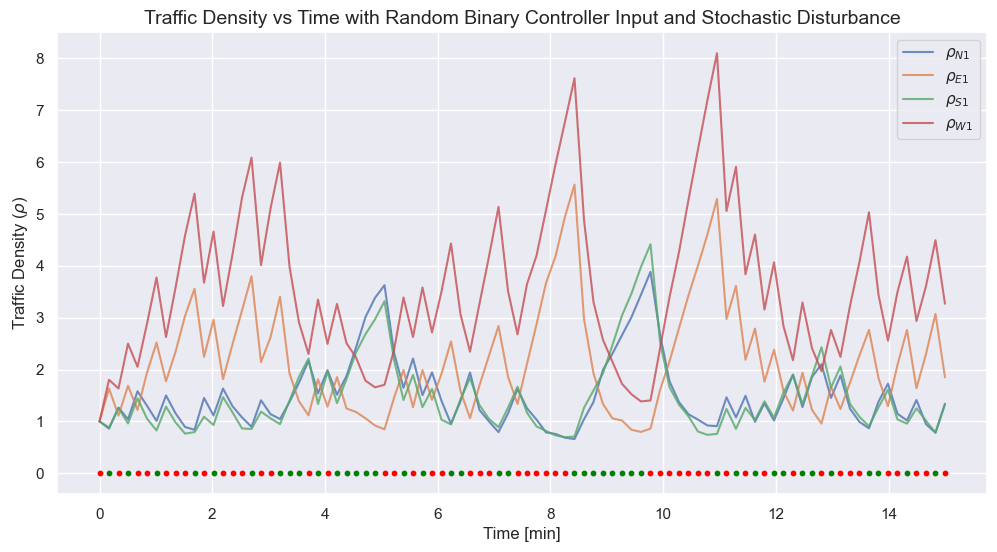

In [13]:
# Standard 
x = np.zeros((4,N))
x[:,0] = initial_state
y = np.zeros((4,N))
y[:,0] = single_intersection.sensor()
z = np.zeros((4,N))
z[:,0] = single_intersection.output() 
# d_stochastic = np.random.uniform(0, 1, (4,N))

# print(f".....{d_stochastic.shape}")



X_d, T_d = initial_state.reshape(-1,1), np.array([0])

for k in range(0, N-1):
    sol = integrate.solve_ivp(single_intersection.process, [t[k], t[k+1]], x[:, k], method='BDF', args=([u_binary[k], d_stochastic[:, k]]))
    # Force non-negative densities
    sol.y[sol.y < 0] = 0
    x[:, k+1] = sol.y[:, -1]
    X_d = np.append(X_d, x[:, k+1].reshape(4,1), axis=1)
    T_d = np.append(T_d, sol.t[-1])
k = N-1


plt.figure(figsize=(12, 6))
plt.plot(T_d/60, X_d.T, linestyle='-', alpha=0.8, markersize=5)
# Marking the controller values 
# plt.plot(T_d/60, u_binary, linestyle='-', marker='o', alpha=0.5)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Random Binary Controller Input and Stochastic Disturbance', fontsize=14)
# Mark switch points on the x-axis
c = lambda a: 'red' if a == 0 else 'green'
for i, x in enumerate(T_d/60):
    # plt.axvline(x=x, color=c(u_binary[i]), linestyle='--', alpha=0.7)  # Vertical line at each switch point
    plt.scatter(x, 0, color=c(u_binary[i]), s=10, zorder=3) 

plt.savefig('figures/one_intersection/rho_t_rand_bin_control_stoch_dist.png', dpi=300)
plt.show()

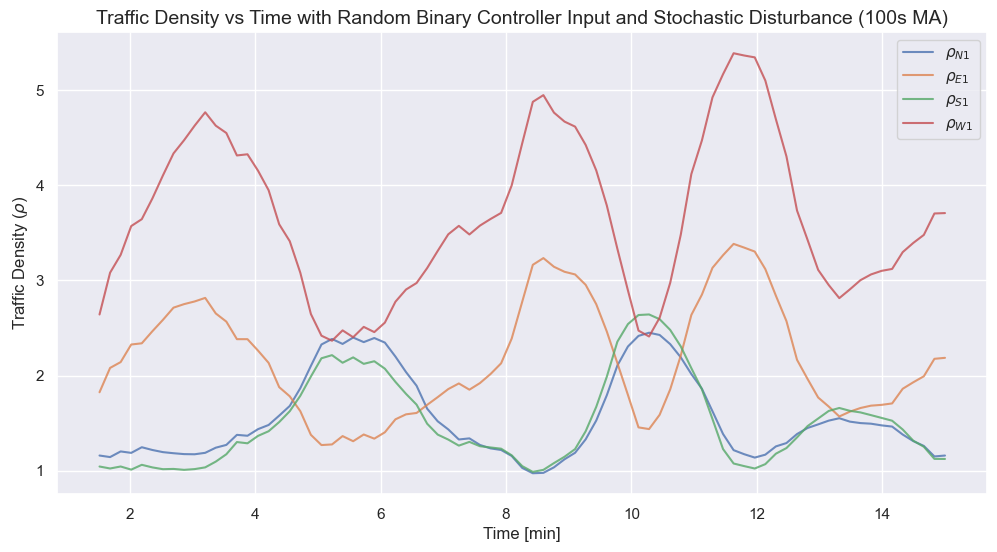

In [14]:

# Plot moving average of density values
plt.figure(figsize=(12, 6))
window = 10
for i in range(4):
    plt.plot(T_d[9:]/60, np.convolve(X_d[i, :], np.ones(window)/window, mode='valid'), linestyle='-', alpha=0.8)
plt.xlabel('Time [min]')
plt.ylabel(r'Traffic Density ($\rho$)')
plt.legend([r'$\rho_{N1}$', r'$\rho_{E1}$', r'$\rho_{S1}$', r'$\rho_{W1}$'])
plt.title('Traffic Density vs Time with Random Binary Controller Input and Stochastic Disturbance (100s MA)', fontsize=14)
plt.savefig('figures/one_intersection/rho_t_rand_bin_control_stoch_dist_moving_avg.png', dpi=300)
plt.show()